In [1]:

import torch
import torchaudio
import numpy as np
import os
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
from IPython.lib.display import Audio

from decaynet_toolbox import DecaynetToolbox
from utils import plot_waveform, plot_fft

In [2]:
## Parameters
audio_path = '/m/cs/work/falconr1/datasets/MusicSamples'
audio_path = '/Volumes/scratch/work/falconr1/datasets/MusicSamples'
#rir_fname = 'Single_503_1_RIR.wav'  # Single slope clean
#rir_fname = 'Single_502_1_RIR.wav'
#rir_fname = 'Single_EE_lobby_1_RIR.wav'  # Long tail

audio_path = '/Volumes/scratch/elec/t40527-hybridacoustics/datasets/summer830/raw_rirs'
#rir_fname = '0825_1_raw_rirs.wav'
#rir_fname = '0825_4_raw_rirs.wav'
#rir_fname = '0001_4_raw_rirs.wav'  # Huge
rir_fname = '0001_1_raw_rirs.wav'  # First measurement


#precomputed_path = '/Volumes/scratch/elec/t40527-hybridacoustics/datasets/decayfitting/summer830'
precomputed_path = '/Volumes/scratch/elec/t40527-hybridacoustics/datasets/decayfit_toolbox/summer830'
precomputed_fname = 'edcs.mat'

torch.Size([32, 120000])
The impulse has 32 channels (before selecting the first one).
The impulse has 120000 timesteps at 48000 sampling rate = 2.5 seconds.


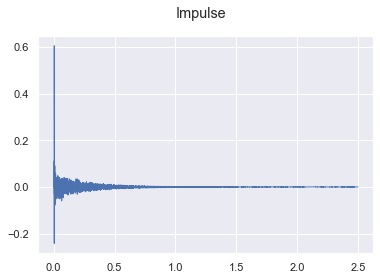

In [3]:
# Load some impulse
impulse, fs = torchaudio.load(os.path.join(audio_path, rir_fname))
channels = impulse.shape[0]
if impulse.shape[0] > 1 and len(impulse.shape) > 1:
    print(impulse.shape)
    impulse = impulse[0:1,:]
    
print(f'The impulse has {channels} channels (before selecting the first one).')
print(f'The impulse has {impulse.shape[-1]} timesteps at {fs} sampling rate = {impulse.shape[-1] / fs} seconds.')

plot_waveform(impulse, fs, title='Impulse')
Audio(impulse, rate=fs, autoplay=False)

In [4]:
# Load a precomputed EDC
f_edcs = h5py.File(os.path.join(precomputed_path, precomputed_fname), 'r')
precomputed_edcs = torch.from_numpy(np.array(f_edcs.get('summer830edcs/edcs'))).float().view(-1, 2400)
for rir_idx in tqdm(range(precomputed_edcs.shape[0])):
    this_edc = precomputed_edcs[rir_idx, :]
    this_edc_nozeros = this_edc[this_edc > 0]
    this_edc[this_edc == 0] = this_edc_nozeros[-1]
    this_edc = this_edc.view(1, -1)
    precomputed_edcs[rir_idx, :] = this_edc

  0%|          | 0/19920 [00:00<?, ?it/s]

In [4]:
# Prepare the model
decaynet = DecaynetToolbox(sample_rate=fs, normalization=True)
print(decaynet)

new_fs = (decaynet.output_size * fs) / impulse.shape[-1] 
print(f'New fs for plotting = {new_fs}')
# Process
prediction = decaynet.estimate_parameters(impulse)
generated_edc = decaynet.estimate_EDC(prediction[0],
                                      prediction[1],
                                      prediction[2],
                                      prediction[3])
print('')
print('Prediction:')
print(f'\t T_vals = {prediction[0]} \n')
print(f'\t A_vals = {prediction[1]} \n')
print(f'\t Noise_vals = {prediction[2]} \n')
print(f'\t scores_slopes = {prediction[3]} \n')
_, n_slopes = torch.max(prediction[3], dim=-1)
print(f'\t pred_slopes = {n_slopes.unsqueeze(-1) + 1} \n')

DecaynetToolbox 0.0.3  
Input fs = 48000 
Output_size = 2400 
Normalization = True 
Filter freqs = [125, 250, 500, 1000, 2000, 4000] 

New fs for plotting = 960.0

Prediction:
	 T_vals = tensor([[9.6683, 5.0450, 2.0684],
        [6.6695, 3.4647, 1.5821],
        [5.2617, 3.2271, 1.6005],
        [5.4307, 3.4508, 1.6474],
        [5.2891, 2.9273, 1.5053],
        [4.6007, 1.8235, 1.1712]]) 

	 A_vals = tensor([[0.0188, 1.3993, 0.0000],
        [0.0103, 0.8150, 0.0000],
        [0.0237, 1.0936, 0.0000],
        [0.0320, 1.0995, 0.0000],
        [0.0135, 0.9255, 0.0000],
        [0.0036, 0.4314, 0.5916]]) 

	 Noise_vals = tensor([[-14.7515],
        [-12.1058],
        [-13.5865],
        [-13.0848],
        [-13.7060],
        [-14.1527]]) 

	 scores_slopes = tensor([[ -6.4284,   7.3787,  -3.5518],
        [ -9.0740,   4.3164,   3.5375],
        [ -7.5439,   4.8834,   0.3318],
        [ -6.8720,   4.8917,  -0.5863],
        [ -8.4530,   4.7483,   1.8409],
        [-10.2271,   4.4015,   4

torch.Size([6, 2400])


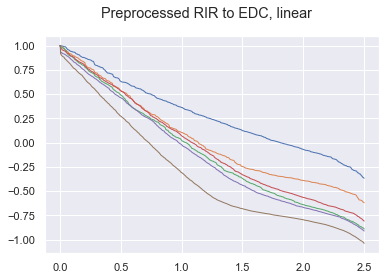

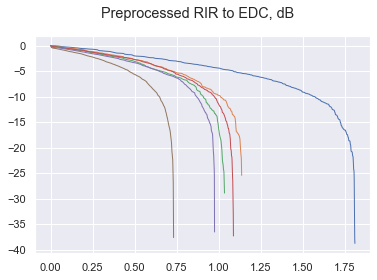

In [5]:
# Validate extracted EDCs
# This is the input to the net
edcs = decaynet.preprocess(impulse)
print(edcs.shape)
plot_waveform(edcs.unsqueeze(0), sample_rate=new_fs, title='Preprocessed RIR to EDC, linear')
plot_waveform(10 * torch.log10(edcs.unsqueeze(0)), sample_rate=new_fs, title='Preprocessed RIR to EDC, dB')

torch.Size([6, 1, 2400])


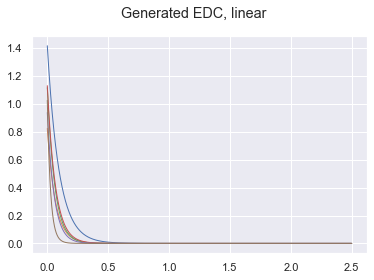

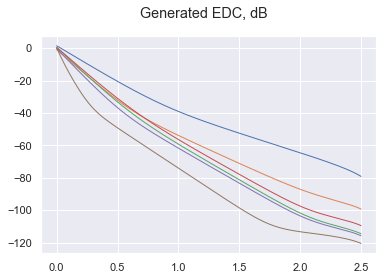

In [7]:
# Plot
print(generated_edc.shape)
#plot_waveform(generated_edc.unsqueeze(0), sample_rate=new_fs, title='Generated EDC, linear')
#plot_waveform(10 * torch.log10(generated_edc.unsqueeze(0)), sample_rate=new_fs, title='Generated EDC, dB')
plot_waveform(generated_edc.permute([1,0,2]), sample_rate=new_fs, title='Generated EDC, linear')
plot_waveform(10 * torch.log10(generated_edc.permute([1,0,2])), sample_rate=new_fs, title='Generated EDC, dB')

In [6]:
# Plot Precomputed
print(precomputed_edcs[0,:].shape)
plot_waveform(precomputed_edcs[0,:].unsqueeze(0), sample_rate=new_fs, title='Precomputed EDC, linear')
plot_waveform(10 * torch.log10(precomputed_edcs[0,:].unsqueeze(0)), sample_rate=new_fs, title='Precomputed EDC, dB')

NameError: name 'precomputed_edcs' is not defined